# **What Factors Influence Booking Cancellations, and How Accurately Can We Predict Whether a Booking Will Be Cancelled?**

### Author: Sheyin Avong  
### Student Number: G21285146
)`


### Key Fields in the Dataset

Here is a brief explanation of the key fields in the dataset to help understand the factors analysed in the study:

- **ADR (Average Daily Rate)**: The average revenue generated per day for a hotel room. It reflects the economic aspect of bookings and is measured in monetary units.

- **Lead Time**: The number of days between the booking date and the arrival date. Longer lead times often indicate a higher likelihood of cancellations as plans are more likely to change over time.

- **Stays in Weekend Nights**: The number of weekend nights (Friday and Saturday) included in the booking. This reflects patterns in leisure travel behaviour.

- **Stays in Week Nights**: The number of weekday nights (Monday to Thursday) included in the booking. This provides insight into business or non-leisure travel trends.

- **Deposit Type**: Indicates whether a deposit was made and its type:
  - **No Deposit**: No upfront payment.
  - **Non-Refundable**: Payment made is not refundable.
  - **Refundable**: Payment is refundable under certain conditions.

- **Market Segment**: Categorises how the booking was made:
  - Examples include **Online Travel Agencies (OTA)**, **Groups**, and **Corporate** bookings.

- **Is Canceled**: The target variable indicating whether a booking was cancelled (`1`) or not (`0`).

These fields were analysed to determine their influence on cancellations and included in the predictive models.


We start by loading the necesssary libraries needed for this analysis

In [15]:
# Load necessary libraries
library(tidyverse)
library(readr)
library(naniar)
library(patchwork)
library(ggplot2)
library(ggcorrplot)
library(caret)
library(dplyr)
library(pROC)
library(randomForest)

## **Access the file and check the dataset**
We start by accessing the file, checking the structure of the dataset and finding out how many rows and columns are in the dataset. From the results there are 119,390 rows with 32 columns

In [17]:
# Define the file path
file_path <- "C:/Users/sheyi/OneDrive/Documents/rassignment/hotel_bookings.csv"

# Load the dataset without showing column types message
hotel_data <- read_csv(file_path, show_col_types = FALSE)

# Check the structure of the dataset
glimpse(hotel_data)

# Print the number of rows and columns
cat("Dataset Dimensions:", dim(hotel_data), "\n")


Rows: 119,390
Columns: 32
$ hotel                          <chr> "Resort Hotel", "Resort Hotel", "Resort…
$ is_canceled                    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, …
$ lead_time                      <dbl> 342, 737, 7, 13, 14, 14, 0, 9, 85, 75, …
$ arrival_date_year              <dbl> 2015, 2015, 2015, 2015, 2015, 2015, 201…
$ arrival_date_month             <chr> "July", "July", "July", "July", "July",…
$ arrival_date_week_number       <dbl> 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,…
$ arrival_date_day_of_month      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ stays_in_weekend_nights        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ stays_in_week_nights           <dbl> 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, …
$ adults                         <dbl> 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ children                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ babies                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ meal        

## **Checking for Missing Values**

To ensure data quality and completeness, I checked for missing values across all variables in the dataset

# A tibble: 1 × 2
  Variable MissingCount
  <chr>           <int>
1 children            4


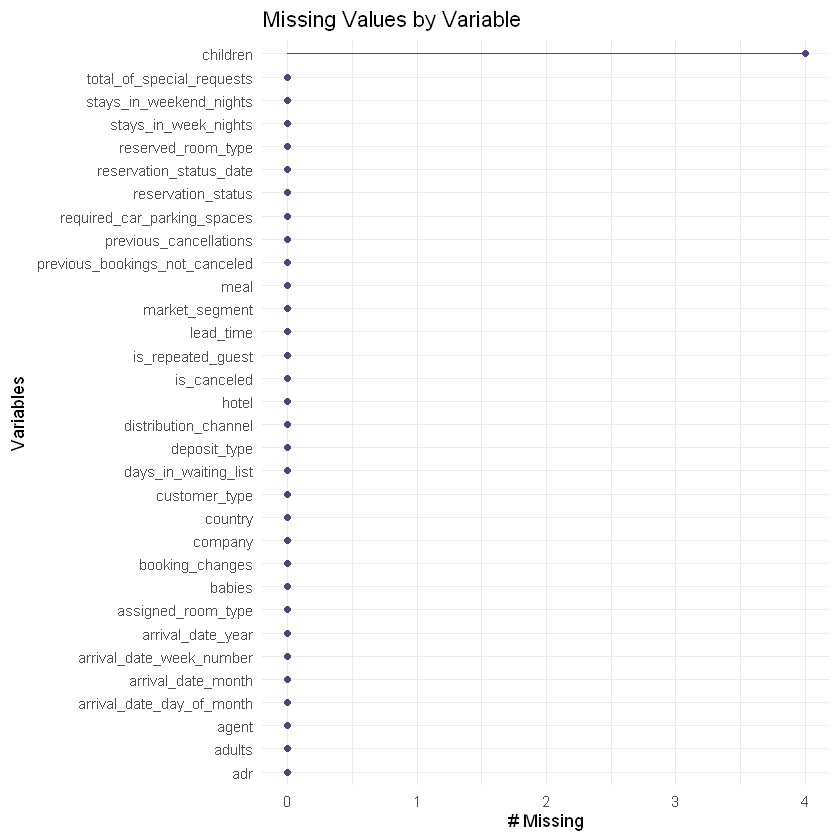

In [24]:
# Check for missing values
missing_summary <- hotel_data %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "Variable", values_to = "MissingCount")

# Display only variables with missing values
missing_summary_with_na <- missing_summary %>%
  filter(MissingCount > 0)

print(missing_summary_with_na)
# Visualise missing values
gg_miss_var(hotel_data) +
  labs(title = "Missing Values by Variable")


### Findings:
- Only the `children` variable has missing values, with **4 missing entries**.

### Visualisation:
The plot above highlights the number of missing values by variable. Since the missing data is minimal, it can be handled effectively.

## **Imputing Missing Values**

To handle the missing values in the dataset, the `children` column was identified as having missing entries. These missing values were imputed using the median value of the column. After imputation, the dataset was verified to ensure there were no remaining missing values.

# A tibble: 32 × 2
   Variable                  MissingCount
   <chr>                            <int>
 1 hotel                                0
 2 is_canceled                          0
 3 lead_time                            0
 4 arrival_date_year                    0
 5 arrival_date_month                   0
 6 arrival_date_week_number             0
 7 arrival_date_day_of_month            0
 8 stays_in_weekend_nights              0
 9 stays_in_week_nights                 0
10 adults                               0
# ℹ 22 more rows


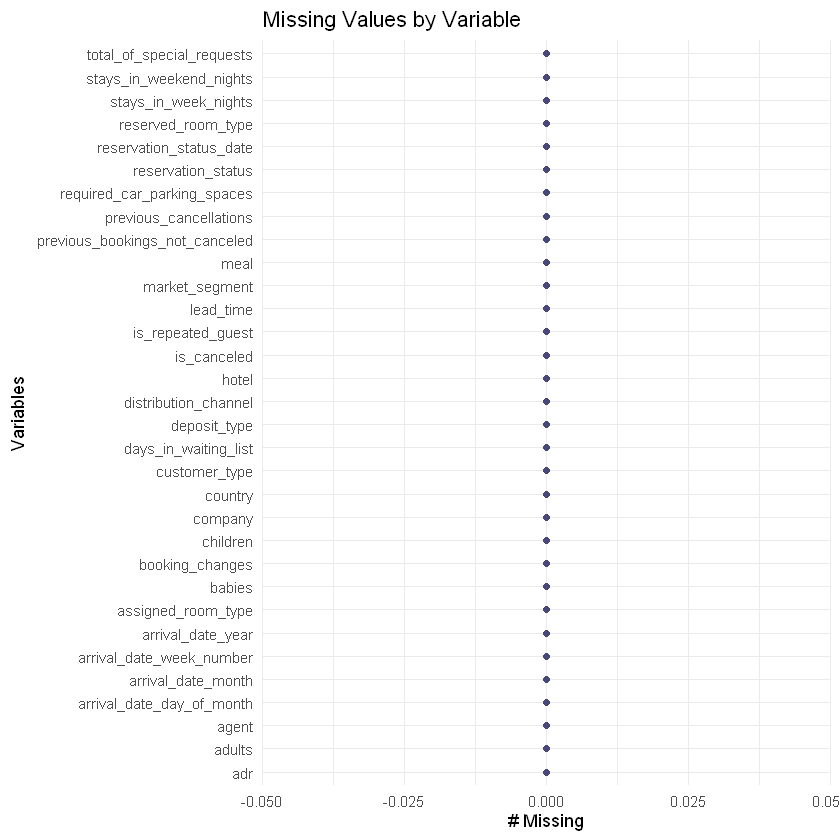

In [46]:
# Impute missing values in the 'children' column with the median
hotel_data <- hotel_data %>%
  mutate(children = ifelse(is.na(children), median(children, na.rm = TRUE), children))

# Verify that there are no missing values remaining
missing_summary_after_imputation <- hotel_data %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "Variable", values_to = "MissingCount")

print(missing_summary_after_imputation)

#visualise if there are any missing variables
gg_miss_var(hotel_data) +
  labs(title = "Missing Values by Variable")

## **Exploring the Distribution of Numerical Variables**

To better understand the data, histograms were plotted for key numerical variables such as `lead_time`, `adr` (Average Daily Rate), `stays_in_weekend_nights`, and `stays_in_week_nights`. These visualisations provide insights into the spread and skewness of the data.


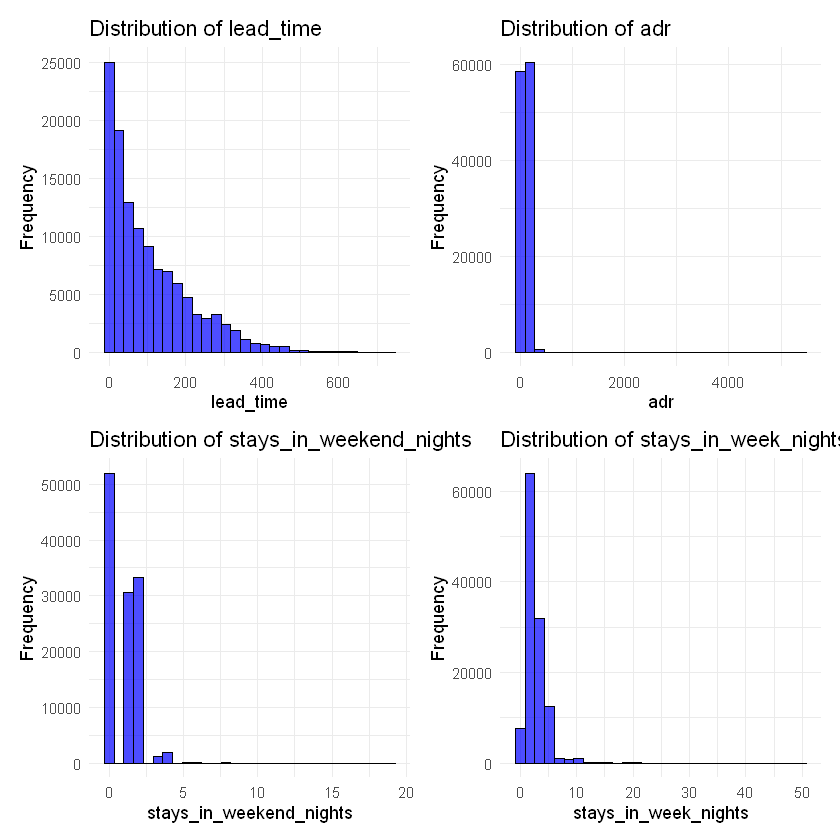

In [49]:
# Define numerical variables
numeric_vars <- c("lead_time", "adr", "stays_in_weekend_nights", "stays_in_week_nights")

# Plot histograms for numerical variables
library(ggplot2)
plots <- lapply(numeric_vars, function(var) {
  ggplot(hotel_data, aes_string(x = var)) +
    geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
    labs(title = paste("Distribution of", var), x = var, y = "Frequency") +
    theme_minimal()
})

# Arrange plots
library(patchwork)
wrap_plots(plots, ncol = 2)

## **Observations**: ##

**Lead Time**:
The distribution is highly right-skewed, with most bookings occurring within a shorter lead time.
Some bookings have very high lead times, which might indicate outliers.

**ADR (Average Daily Rate)**:
The majority of values are concentrated on the lower end, but there are a few instances of very high rates.

**Stays in Weekend Nights**:
Most bookings involve a few nights, with a sharp drop-off for longer stays.

**Stays in Week Nights**:
Similar to weekend nights, shorter stays are far more common, with very few extended stays.

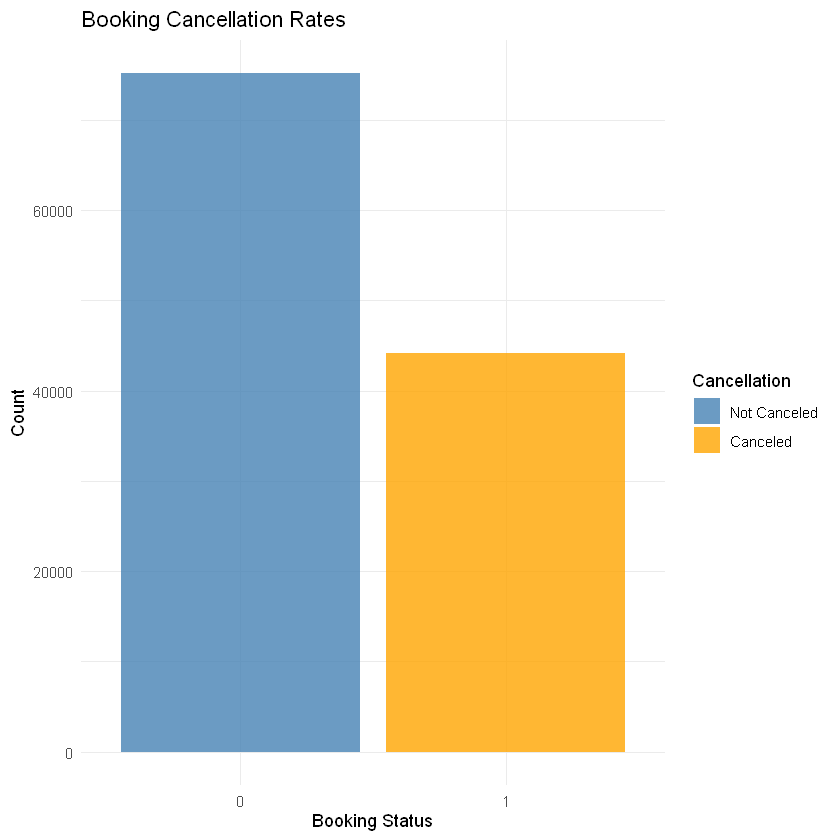

In [51]:
# Plot cancellation distribution
ggplot(hotel_data, aes(x = factor(is_canceled), fill = factor(is_canceled))) +
  geom_bar(alpha = 0.8) +
  scale_fill_manual(values = c("steelblue", "orange"), labels = c("Not Canceled", "Canceled")) +
  labs(title = "Booking Cancellation Rates", x = "Booking Status", y = "Count", fill = "Cancellation") +
  theme_minimal()

## **Booking Cancellation Rates**

This visualisation illustrates the distribution of bookings that were either cancelled or not cancelled. It provides an overview of the cancellation rates, allowing us to understand the balance between the two outcomes.

### Observation:
A significant proportion of bookings were not cancelled compared to those that were cancelled.
This imbalance highlights the need to account for cancellation rates in our analysis, as they may impact the prediction model.

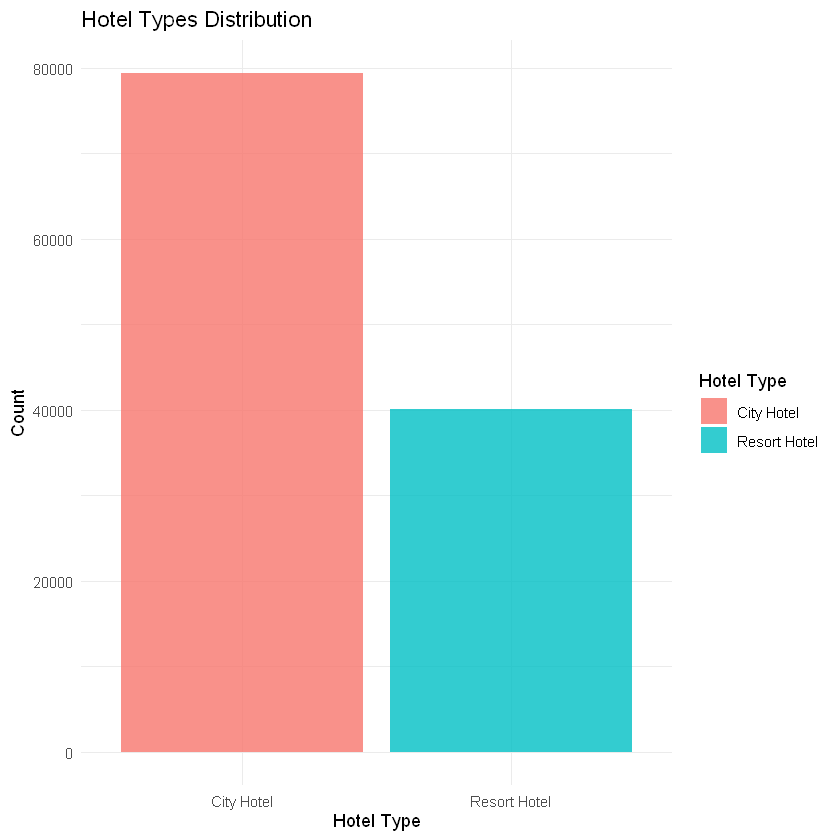

In [75]:
# Plot distribution of hotel types
ggplot(hotel_data, aes(x = hotel, fill = hotel)) +
  geom_bar(alpha = 0.8) +
  labs(title = "Hotel Types Distribution", x = "Hotel Type", y = "Count", fill = "Hotel Type") +
  theme_minimal()


### **Hotel Types Distribution**

This visualisation shows the distribution of hotel types in the dataset. It highlights that the majority of bookings are for City Hotels compared to Resort Hotels.

### **Insights:**
- The dataset is heavily skewed towards City Hotels, which make up a significantly larger proportion of the bookings.
- This imbalance might affect cancellation trends and should be considered during analysis.


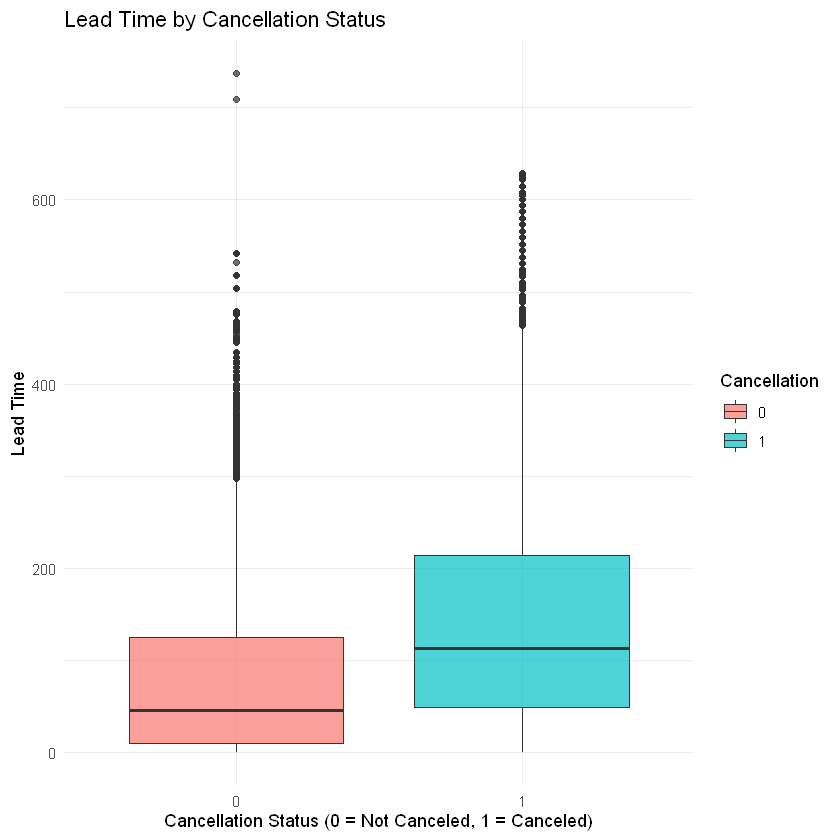

In [55]:
# creating total stay variable for visualisation 
hotel_data <- hotel_data %>%
  mutate(total_stay = stays_in_weekend_nights + stays_in_week_nights)
# Lead Time
ggplot(hotel_data, aes(x = factor(is_canceled), y = lead_time, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Lead Time by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Lead Time",
    fill = "Cancellation"
  ) +
  theme_minimal()



### **Lead Time by Cancellation Status**

This boxplot illustrates the relationship between lead time (the number of days between booking and check-in) and booking cancellation status.

### **Insights:**
- Bookings that are cancelled (cancellation status = 1) tend to have significantly higher lead times compared to bookings that are not cancelled (cancellation status = 0).
- This indicates that customers who book far in advance are more likely to cancel their reservations, possibly due to changes in their plans over time.
- Outliers can be observed for both groups, with extremely high lead times for some bookings.


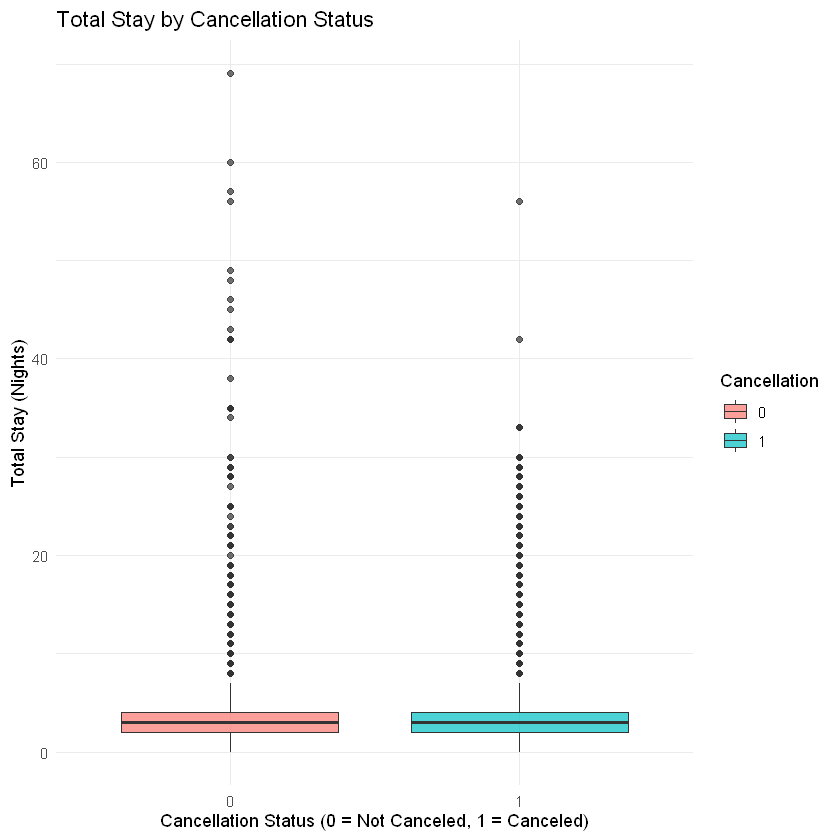

In [59]:
# Total Stay
ggplot(hotel_data, aes(x = factor(is_canceled), y = total_stay, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Total Stay by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Total Stay (Nights)",
    fill = "Cancellation"
  ) +
  theme_minimal()


### **Total Stay by Cancellation Status**

This boxplot depicts the relationship between the total stay duration (in nights) and the cancellation status of bookings.

### **Insights:**
- The median total stay is similar for both cancelled (cancellation status = 1) and non-cancelled bookings (cancellation status = 0), suggesting that total stay duration is not a strong differentiator between the two groups.
- A few extreme outliers are present, representing bookings with exceptionally long total stays.
- The interquartile ranges and distributions for both groups are largely overlapping, further indicating minimal variation in total stay duration based on cancellation status.


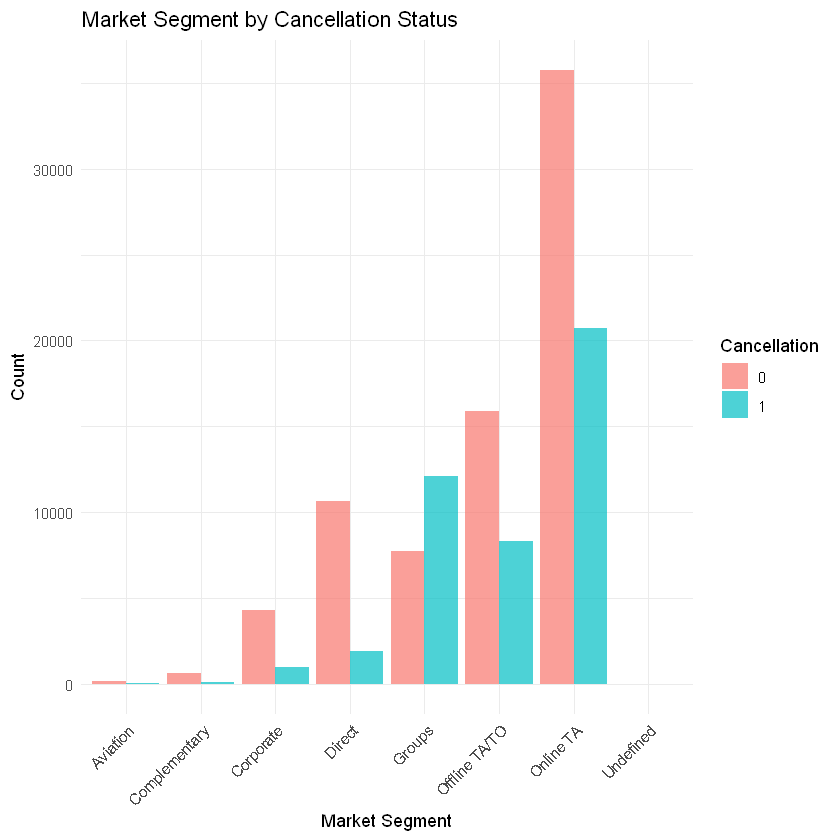

In [61]:
# Market Segment
ggplot(hotel_data, aes(x = market_segment, fill = factor(is_canceled))) +
  geom_bar(position = "dodge", alpha = 0.7) +
  labs(
    title = "Market Segment by Cancellation Status",
    x = "Market Segment",
    y = "Count",
    fill = "Cancellation"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### **Market Segment by Cancellation Status**

This bar chart compares the distribution of cancellations across different market segments.

### **Insights:**
- The **Online TA (Travel Agents)** segment shows the highest number of bookings, with a significant portion of those being cancelled. This indicates that bookings from online travel agents are more prone to cancellations compared to other segments.
- The **Groups** segment also has a high cancellation rate, suggesting a strong relationship between group bookings and cancellations.
- **Direct** and **Corporate** bookings have noticeably lower cancellation rates, implying that these segments are more stable and less likely to result in cancellations.
- Other segments, such as **Complementary** and **Aviation**, have minimal booking volumes and cancellations, making them less impactful overall.

This visualisation highlights how different market segments contribute to booking cancellations, providing actionable insights for targeted interventions in specific segments.


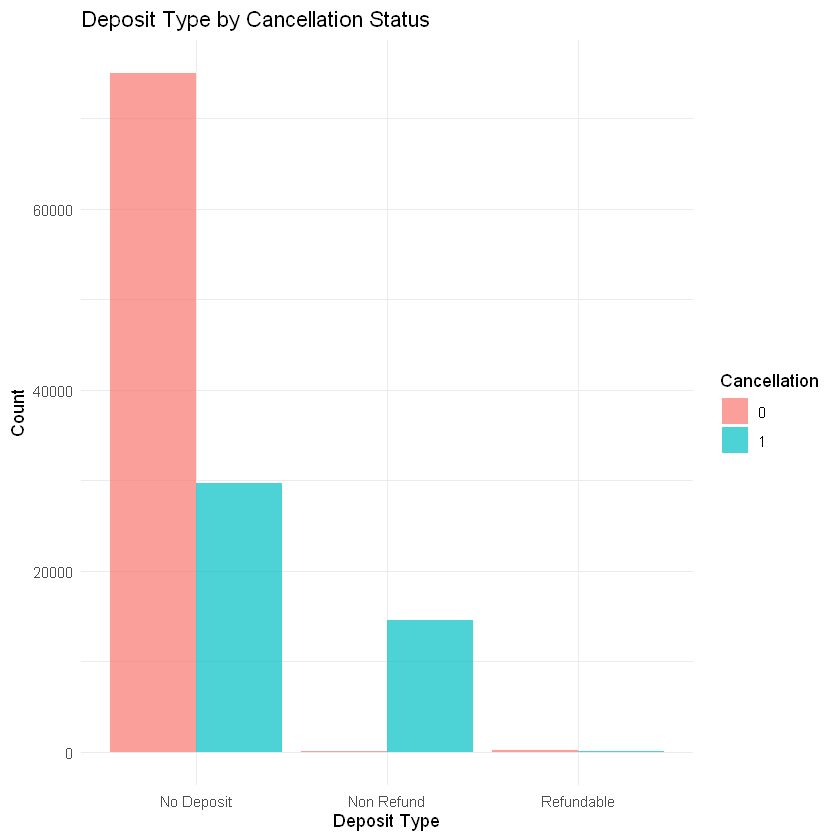

In [63]:
# Deposit Type
ggplot(hotel_data, aes(x = deposit_type, fill = factor(is_canceled))) +
  geom_bar(position = "dodge", alpha = 0.7) +
  labs(
    title = "Deposit Type by Cancellation Status",
    x = "Deposit Type",
    y = "Count",
    fill = "Cancellation"
  ) +
  theme_minimal()

### **Deposit Type by Cancellation Status**

This bar chart illustrates the relationship between deposit types and booking cancellation rates.

### **Insights:**
- **No Deposit**: This category accounts for the majority of bookings, with a significant proportion resulting in cancellations. The absence of a deposit may reduce the customer's commitment to completing their stay, increasing the likelihood of cancellations.
- **Non-Refundable**: Bookings in this category exhibit higher commitment, as cancellations are comparatively fewer. The financial implication of non-refundable deposits likely discourages cancellations.
- **Refundable**: This category shows the lowest volume of bookings and cancellations, suggesting limited usage of refundable deposits in the dataset.

The visualisation highlights that bookings requiring non-refundable deposits tend to have lower cancellation rates, whereas "No Deposit" bookings are associated with higher cancellation rates.


### **Outlier Detection and Winsorisation**

#### **Outlier Detection**
To detect outliers in the dataset, the Interquartile Range (IQR) method was applied to numerical variables: `adr`, `lead_time`, `stays_in_week_nights`, and `stays_in_weekend_nights`. Outliers were identified as values falling outside the range defined by:

- **Lower Bound**: Q1 - 1.5 * IQR
- **Upper Bound**: Q3 + 1.5 * IQR

**Summary of Outliers**:
- **ADR**: 3,793 outliers (3.18% of the data)
- **Lead Time**: 3,005 outliers (2.52% of the data)
- **Stays in Week Nights**: 3,354 outliers (2.81% of the data)
- **Stays in Weekend Nights**: 265 outliers (0.22% of the data)

Outlier detection revealed that `adr` (Average Daily Rate) and `lead_time` had the most significant number of outliers.

#### **Winsorisation**
Winsorisation was applied to cap outliers at the upper and lower bounds calculated using the IQR method. This ensured that extreme values did not overly influence the analysis while preserving the overall data distribution.

**Post-Winsorisation Summary**:
- **ADR**: Values capped between -6.38 and 211.06
- **Lead Time**: Values capped between 0.0 and 373.0
- **Stays in Week Nights**: Values capped between 0.0 and 6.0
- **Stays in Weekend Nights**: Values capped between 0.0 and 5.0

#### **Impact of Winsorisation**
After Winsorisation:
- The data range for each variable is reduced, eliminating extreme values.
- The statistical summaries (mean, median, quartiles) are less influenced by extreme outliers.

This process ensures that the dataset remains robust for further analysis while minimising the influence of extreme values on the results.


In [83]:
# Define a function to summarise outliers using IQR
summarise_outliers <- function(data, variable) {
  Q1 <- quantile(data[[variable]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data[[variable]], 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR_value
  upper_bound <- Q3 + 1.5 * IQR_value
  
  # Count outliers
  num_outliers <- sum(data[[variable]] < lower_bound | data[[variable]] > upper_bound, na.rm = TRUE)
  total_values <- sum(!is.na(data[[variable]]))
  percentage_outliers <- (num_outliers / total_values) * 100
  
  return(data.frame(
    Variable = variable,
    Lower_Bound = lower_bound,
    Upper_Bound = upper_bound,
    Num_Outliers = num_outliers,
    Total_Values = total_values,
    Percentage_Outliers = percentage_outliers
  ))
}

# Select numerical variables
numerical_vars <- c("adr", "lead_time", "stays_in_week_nights", "stays_in_weekend_nights")

# Apply the function to each numerical variable
outliers_summary <- do.call(rbind, lapply(numerical_vars, function(var) summarise_outliers(hotel_data, var)))

# Print the summary of outliers
print(outliers_summary)

# Define a function for Winsorisation
winsorise <- function(data, variable) {
  Q1 <- quantile(data[[variable]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data[[variable]], 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR_value
  upper_bound <- Q3 + 1.5 * IQR_value
  
  # Cap the values
  data[[variable]] <- ifelse(data[[variable]] < lower_bound, lower_bound, data[[variable]])
  data[[variable]] <- ifelse(data[[variable]] > upper_bound, upper_bound, data[[variable]])
  
  return(data)
}

# Variables to Winsorise
numerical_vars <- c("adr", "lead_time", "stays_in_week_nights", "stays_in_weekend_nights")

# Apply Winsorisation to each variable
for (var in numerical_vars) {
  hotel_data <- winsorise(hotel_data, var)
}

# Confirm Winsorisation
print("Winsorisation completed for selected variables.")

summary(hotel_data[numerical_vars])


                    Variable Lower_Bound Upper_Bound Num_Outliers Total_Values
25%                      adr     -15.775     211.065         3793       119390
25%1               lead_time    -195.000     373.000         3005       119390
25%2    stays_in_week_nights      -2.000       6.000         3354       119390
25%3 stays_in_weekend_nights      -3.000       5.000          265       119390
     Percentage_Outliers
25%            3.1769830
25%1           2.5169612
25%2           2.8092805
25%3           0.2219616
[1] "Winsorisation completed for selected variables."


      adr           lead_time     stays_in_week_nights stays_in_weekend_nights
 Min.   : -6.38   Min.   :  0.0   Min.   :0.000        Min.   :0.0000         
 1st Qu.: 69.29   1st Qu.: 18.0   1st Qu.:1.000        1st Qu.:0.0000         
 Median : 94.58   Median : 69.0   Median :2.000        Median :1.0000         
 Mean   :100.66   Mean   :102.2   Mean   :2.406        Mean   :0.9227         
 3rd Qu.:126.00   3rd Qu.:160.0   3rd Qu.:3.000        3rd Qu.:2.0000         
 Max.   :211.06   Max.   :373.0   Max.   :6.000        Max.   :5.0000         

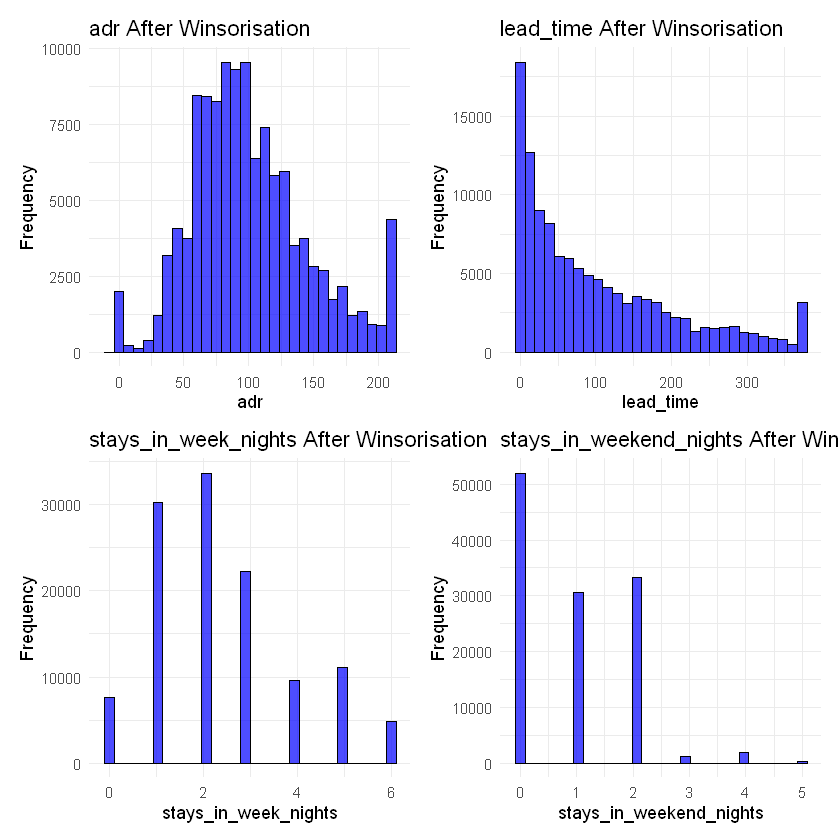

In [91]:
# Define numerical variables for plotting
numerical_vars <- c("adr", "lead_time", "stays_in_week_nights", "stays_in_weekend_nights")

# Create histograms for the numerical variables
plots <- lapply(numerical_vars, function(var) {
  ggplot(hotel_data, aes_string(x = var)) +
    geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
    labs(title = paste(var, "After Winsorisation"), x = var, y = "Frequency") +
    theme_minimal()
})

# Arrange plots in a grid
library(patchwork)
wrap_plots(plots, ncol = 2)

### **Histograms of Variables After Winsorisation**

The histograms above display the distribution of numerical variables after Winsorisation:

1. **ADR (Average Daily Rate)**:
   - The values are capped between -6.38 and 211.06.
   - The distribution remains positively skewed, with most values concentrated around 50 to 150.

2. **Lead Time**:
   - The range is limited between 0 and 373 days.
   - The distribution exhibits a heavy right skew, with most bookings having a lead time of fewer than 100 days.

3. **Stays in Week Nights**:
   - Values are capped between 0 and 6 nights.
   - The data is relatively spread out, with peaks at 1, 2, and 3 nights.

4. **Stays in Weekend Nights**:
   - The range is capped between 0 and 5 nights.
   - The distribution shows that most stays involve 0 or 1 weekend night.

#### **Insights**:
- Winsorisation successfully mitigates the impact of extreme outliers while preserving the overall structure of the data.
- The distributions indicate that the majority of the data lies within expected ranges for each variable, making the dataset more robust for further analysis.


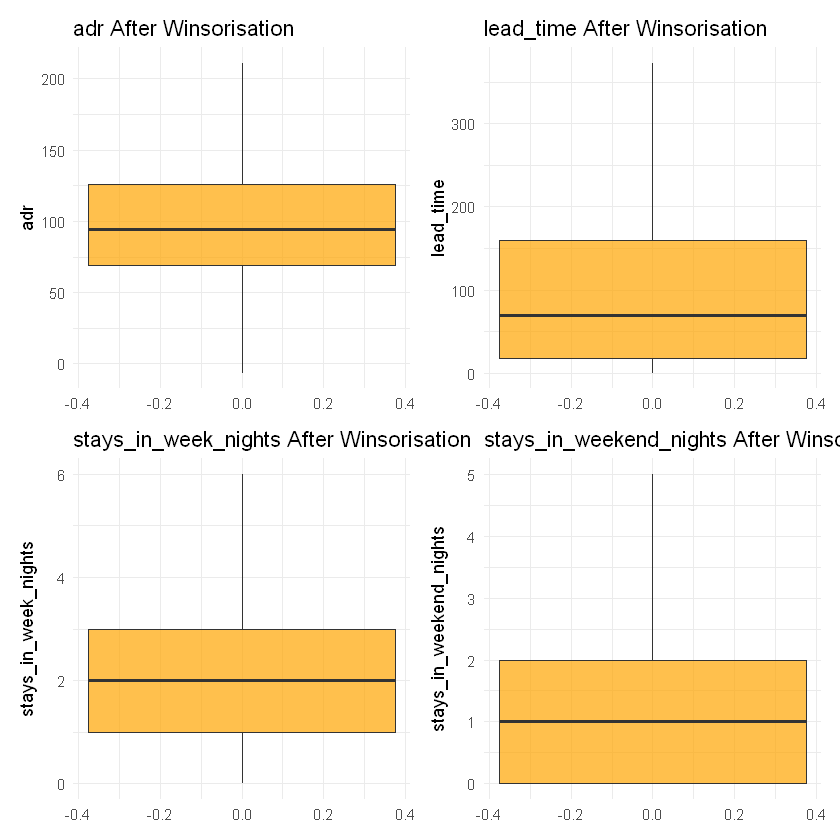

In [96]:
# Boxplots for Winsorised Data
boxplots <- lapply(numerical_vars, function(var) {
  ggplot(hotel_data, aes(y = .data[[var]])) +
    geom_boxplot(fill = "orange", alpha = 0.7) +
    labs(title = paste(var, "After Winsorisation"), y = var) +
    theme_minimal()
})

# Arrange boxplots
wrap_plots(boxplots, ncol = 2)

### **Boxplots of Variables After Winsorisation**

The boxplots above present the distribution of numerical variables after Winsorisation, showing the range, median, and spread of the data:

1. **ADR (Average Daily Rate)**:
   - The distribution is compact, with a median around 100.
   - Most values are within the interquartile range (IQR), and extreme outliers have been capped.

2. **Lead Time**:
   - The median lead time is approximately 100 days.
   - The spread of the data indicates a right-skewed distribution with longer lead times capped.

3. **Stays in Week Nights**:
   - The median stay is around 2 nights.
   - The data is concentrated within a narrow range, with few outliers remaining.

4. **Stays in Weekend Nights**:
   - The median is close to 1 night.
   - The data shows a compact distribution, with most stays involving up to 2 nights.

#### **Insights**:
- Winsorisation effectively caps outliers, ensuring that the visualisation highlights the central tendency and variability of the data.
- The resulting boxplots are more representative of the typical values, which is beneficial for modelling and analysis.


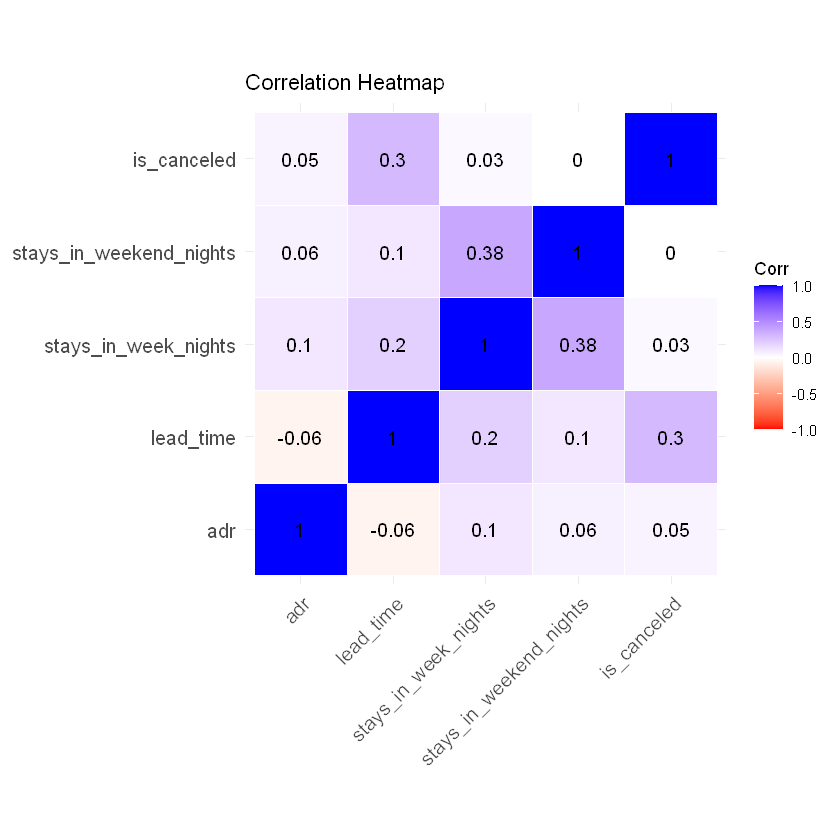

In [102]:
# Compute correlation matrix for numerical variables
cor_matrix <- cor(hotel_data %>% select(adr, lead_time, stays_in_week_nights, stays_in_weekend_nights, is_canceled))

# Load ggcorrplot for visualisation
library(ggcorrplot)

# Plot correlation heatmap
ggcorrplot(cor_matrix, lab = TRUE, outline.color = "white", colors = c("red", "white", "blue")) +
  labs(title = "Correlation Heatmap")

### **Correlation Heatmap After Winsorisation**

The heatmap above displays the correlation matrix for the numerical variables in the dataset after Winsorisation. Key observations include:

- **`lead_time` and `is_canceled`**: A moderately positive correlation of **0.3**, suggesting that longer lead times are associated with a higher likelihood of cancellations.
- **`stays_in_week_nights` and `stays_in_weekend_nights`**: A positive correlation of **0.38**, indicating that guests who stay longer during the week also tend to have longer weekend stays.
- **`adr` (Average Daily Rate)**: Shows weak correlations with all other variables, indicating minimal influence of daily rate on cancellation or stay characteristics.
- **`is_canceled` and `stays_in_week_nights` / `stays_in_weekend_nights`**: Weak correlations, suggesting the duration of stay has limited direct impact on cancellations.

#### **Insights**:
- The correlation matrix highlights key relationships between variables, particularly between `lead_time` and `is_canceled`, which could be an important predictor for cancellation likelihood.
- The weak correlations for most variables with `is_canceled` indicate the need for more complex models or interactions to understand cancellations better.


### **Feature Selection and Data Preprocessing**

#### **Feature Selection**:
- The dataset has been reduced to include only the relevant features for predicting cancellations:
  - `is_canceled`: The target variable.
  - Predictors include:
    - Numerical features: `lead_time`, `adr` (Average Daily Rate), `stays_in_week_nights`, and `stays_in_weekend_nights`.
    - Categorical features: `hotel`, `market_segment`, `deposit_type`, and `customer_type`.

#### **Encoding Categorical Variables**:
- Categorical variables (`hotel`, `market_segment`, `deposit_type`, `customer_type`) were encoded using **one-hot encoding**, creating binary columns for each category. This ensures compatibility with machine learning models.

#### **Train-Test Split**:
- The dataset was split into:
  - **Training Set**: 70% of the data (**83,573 rows**).
  - **Testing Set**: 30% of the data (**35,817 rows**).

#### **Normalisation**:
- Numerical features (`lead_time`, `adr`, `stays_in_week_nights`, `stays_in_weekend_nights`) were **normalised** using z-score scaling to standardise the feature range. This step is particularly important for models sensitive to feature scaling, such as logistic regression.

#### **Importance of Preprocessing**:
- These steps prepare the dataset for modelling by ensuring:
  - Balanced and representative data for training and testing.
  - Consistency in feature scales for numerical predictors.


In [117]:
# Select features
selected_features <- hotel_data %>%
  select(is_canceled, lead_time, adr, stays_in_week_nights, stays_in_weekend_nights, 
         hotel, market_segment, deposit_type, customer_type)

# Encode categorical variables using one-hot encoding
dummy_vars <- dummyVars("~ .", data = selected_features, fullRank = TRUE)
encoded_data <- data.frame(predict(dummy_vars, newdata = selected_features))

# Split into training and testing subsets
set.seed(123)  # For reproducibility
train_index <- createDataPartition(encoded_data$is_canceled, p = 0.7, list = FALSE)
train_data <- encoded_data[train_index, ]
test_data <- encoded_data[-train_index, ]

# Normalise numerical variables (for Logistic Regression)
num_vars <- c("lead_time", "adr", "stays_in_week_nights", "stays_in_weekend_nights")
preprocess <- preProcess(train_data[, num_vars], method = c("center", "scale"))
train_data[, num_vars] <- predict(preprocess, train_data[, num_vars])
test_data[, num_vars] <- predict(preprocess, test_data[, num_vars])

# Confirm the structure of training and testing data
cat("Training Data Dimensions:", dim(train_data), "\n")
cat("Testing Data Dimensions:", dim(test_data), "\n")

Training Data Dimensions: 83573 18 
Testing Data Dimensions: 35817 18 


In [113]:
# Train a logistic regression model
logistic_model <- glm(
  is_canceled ~ ., 
  data = train_data, 
  family = binomial
)

# Display model summary
summary(logistic_model)


# Predict probabilities on the testing dataset
test_data$predicted_prob <- predict(logistic_model, newdata = test_data, type = "response")

# Convert probabilities to binary predictions (threshold = 0.5)
test_data$predicted_class <- ifelse(test_data$predicted_prob > 0.5, 1, 0)




Call:
glm(formula = is_canceled ~ ., family = binomial, data = train_data)

Coefficients: (1 not defined because of singularities)
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -1.478764   0.200560  -7.373 1.67e-13 ***
lead_time                     0.410698   0.010349  39.684  < 2e-16 ***
adr                           0.123881   0.009218  13.440  < 2e-16 ***
stays_in_week_nights          0.076243   0.009578   7.960 1.72e-15 ***
stays_in_weekend_nights       0.064280   0.009239   6.958 3.46e-12 ***
hotelResort.Hotel            -0.271546   0.019315 -14.059  < 2e-16 ***
market_segmentComplementary  -0.066100   0.232504  -0.284  0.77618    
market_segmentCorporate      -0.169554   0.200171  -0.847  0.39697    
market_segmentDirect         -0.490157   0.195961  -2.501  0.01237 *  
market_segmentGroups          0.433559   0.197457   2.196  0.02811 *  
market_segmentOffline.TA.TO  -0.393231   0.195465  -2.012  0.04424 *  
market_segmentOn

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


### Logistic Regression Model Summary

The logistic regression model tries to predict if a booking will be cancelled (`is_canceled`) based on several features, such as lead time, average daily rate (ADR), and market segment. It assigns a weight (called a "coefficient") to each feature to understand how important it is for predicting cancellations.

Key points from the model:
- **Positive coefficients** (e.g., `lead_time` and `adr`) mean that as these values increase, the likelihood of a cancellation increases.
- **Negative coefficients** (e.g., `hotelResort.Hotel`) mean that these features reduce the likelihood of a cancellation.
- Some categories, like `market_segmentComplementary`, are less significant in predicting cancellations because their p-values are large (e.g., 0.776), which means they don't have a strong relationship with cancellations.

### Model Fit and Performance
- The model successfully found the best fit for the data (this is called "convergence").
- The **AIC (Akaike Information Criterion)** value is 81901, which helps measure how well the model fits the data. A lower AIC means a better fit.


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 21625  7919
         1   837  5436
                                       
               Accuracy : 0.7555       
                 95% CI : (0.751, 0.76)
    No Information Rate : 0.6271       
    P-Value [Acc > NIR] : < 2.2e-16    
                                       
                  Kappa : 0.4143       
                                       
 Mcnemar's Test P-Value : < 2.2e-16    
                                       
            Sensitivity : 0.9627       
            Specificity : 0.4070       
         Pos Pred Value : 0.7320       
         Neg Pred Value : 0.8666       
             Prevalence : 0.6271       
         Detection Rate : 0.6038       
   Detection Prevalence : 0.8249       
      Balanced Accuracy : 0.6849       
                                       
       'Positive' Class : 0            
                                       


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.7893547 


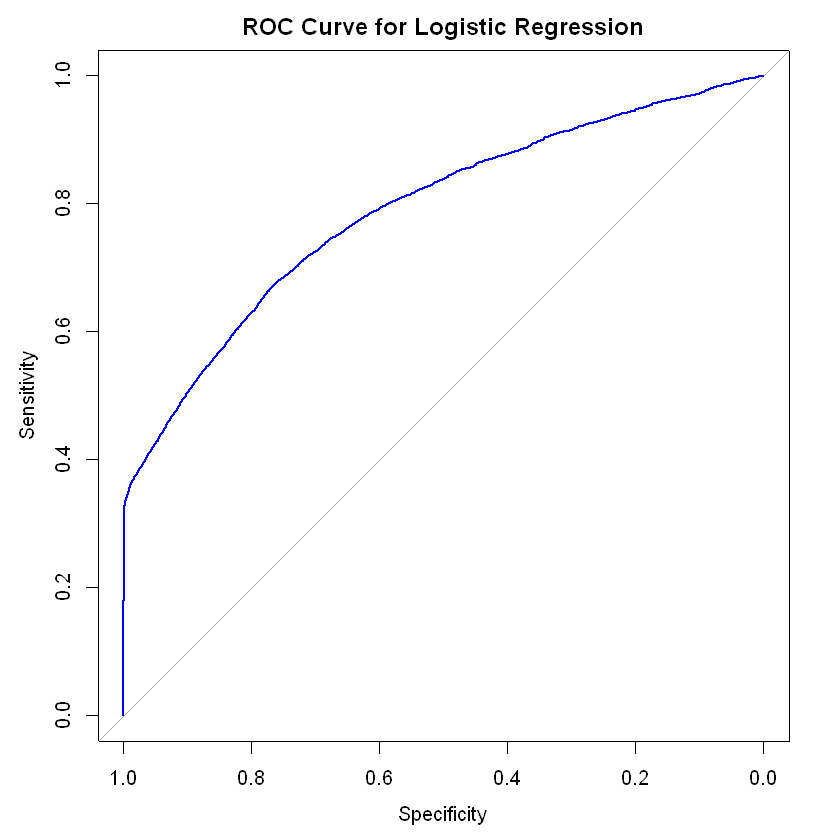

In [115]:
# Confusion Matrix
conf_matrix <- confusionMatrix(
  factor(test_data$predicted_class), 
  factor(test_data$is_canceled)
)
print(conf_matrix)

# AUC-ROC Curve
roc_curve <- roc(test_data$is_canceled, test_data$predicted_prob)
plot(roc_curve, col = "blue", main = "ROC Curve for Logistic Regression")
auc_value <- auc(roc_curve)
cat("AUC:", auc_value, "\n")


### Logistic Regression Model Evaluation

The model was evaluated using a confusion matrix and additional metrics to measure its performance.

#### Key Metrics:
1. **Accuracy**: 75.55% of the predictions made by the model were correct.
   - This means the model correctly identified cancellations and non-cancellations 75.55% of the time.

2. **Sensitivity (Recall for Non-Cancellations)**: 96.27%
   - The model is very good at identifying bookings that were not cancelled (`class 0`).

3. **Specificity (Recall for Cancellations)**: 40.70%
   - The model struggles more with identifying cancellations (`class 1`).

4. **Positive Predictive Value (Precision for Non-Cancellations)**: 73.20%
   - Of all the bookings predicted as non-cancelled, 73.20% were correct.

5. **Negative Predictive Value (Precision for Cancellations)**: 86.66%
   - Of all the bookings predicted as cancelled, 86.66% were correct.

6. **Balanced Accuracy**: 68.49%
   - This is an average of sensitivity and specificity, giving a more balanced view of the model’s performance.

7. **AUC (Area Under the Curve)**: 0.789
   - The AUC measures how well the model distinguishes between cancellations and non-cancellations. A score of 0.789 indicates decent performance.

#### Observations:
- The model performs well in predicting non-cancellations but is less effective at identifying cancellations.
- The **low specificity** indicates the need for improvement in detecting cancellations.
- The **AUC of 0.789** suggests that the model has a good ability to separate cancelled and non-cancelled bookings overall.

#### Note on Warnings:
The output also includes information that the model correctly set the positive class (`0` for not cancelled) and the direction for calculations. This helps ensure accurate results.


In [124]:

# Ensure the target variable is a factor
hotel_data$is_canceled <- as.factor(hotel_data$is_canceled)

# Create an 80-20 train-test split
set.seed(123)  
train_index <- createDataPartition(hotel_data$is_canceled, p = 0.8, list = FALSE)

# Split data
train_data <- hotel_data[train_index, ]
test_data <- hotel_data[-train_index, ]

# Confirm the structure of train and test data
cat("Training Data Dimensions:", dim(train_data), "\n")
cat("Testing Data Dimensions:", dim(test_data), "\n")

# Convert categorical variables to factors
train_data <- train_data %>%
  mutate(
    hotel = as.factor(hotel),
    market_segment = as.factor(market_segment),
    deposit_type = as.factor(deposit_type),
    customer_type = as.factor(customer_type),
    is_canceled = as.factor(is_canceled)
  )

test_data <- test_data %>%
  mutate(
    hotel = as.factor(hotel),
    market_segment = as.factor(market_segment),
    deposit_type = as.factor(deposit_type),
    customer_type = as.factor(customer_type),
    is_canceled = as.factor(is_canceled)
  )

# Verify transformation
str(train_data)


# Train the model
set.seed(123)
rf_model <- randomForest(
  is_canceled ~ lead_time + adr + stays_in_week_nights + stays_in_weekend_nights +
    hotel + market_segment + deposit_type + customer_type,
  data = train_data,  
  ntree = 500,    
  mtry = 3,       
  importance = TRUE  
)

# Print model summary
print(rf_model)

# Ensure test data levels match train data levels
test_data$hotel <- factor(test_data$hotel, levels = levels(train_data$hotel))
test_data$market_segment <- factor(test_data$market_segment, levels = levels(train_data$market_segment))
test_data$deposit_type <- factor(test_data$deposit_type, levels = levels(train_data$deposit_type))
test_data$customer_type <- factor(test_data$customer_type, levels = levels(train_data$customer_type))

# Verify that levels match
str(test_data)


# Make predictions on the test set
rf_predictions <- predict(rf_model, test_data)

# Convert predictions and actual values to factors
rf_predictions <- as.factor(rf_predictions)
test_data$is_canceled <- as.factor(test_data$is_canceled)

# Confusion Matrix
rf_conf_matrix <- confusionMatrix(rf_predictions, test_data$is_canceled)
# Print the confusion matrix results
print(rf_conf_matrix)

Training Data Dimensions: 95513 33 
Testing Data Dimensions: 23877 33 
tibble [95,513 × 33] (S3: tbl_df/tbl/data.frame)
 $ hotel                         : Factor w/ 2 levels "City Hotel","Resort Hotel": 2 2 2 2 2 2 2 2 2 2 ...
 $ is_canceled                   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 2 2 ...
 $ lead_time                     : num [1:95513] 342 373 7 14 14 0 9 85 75 23 ...
 $ arrival_date_year             : num [1:95513] 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : chr [1:95513] "July" "July" "July" "July" ...
 $ arrival_date_week_number      : num [1:95513] 27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : num [1:95513] 1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_weekend_nights       : num [1:95513] 0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : num [1:95513] 0 0 1 2 2 2 2 3 3 4 ...
 $ adults                        : num [1:95513] 2 2 1 2 2 2 2 2 2 2 ...
 $ children                      : num [1:95513] 0 0 0 0 0 0 0 0 0 0 .

### Random Forest Model Evaluation

#### Training and Testing Data
- The dataset was split into:
  - **Training Data**: 80% (95,513 records).
  - **Testing Data**: 20% (23,877 records).
- Categorical variables were converted to factors to ensure compatibility with the Random Forest model.

#### Model Summary
- **Number of Trees**: 500
- **Variables Tried at Each Split**: 3
- **Out-of-Bag (OOB) Error Rate**: 19.78%
  - This is an internal estimate of prediction error during training.

#### Confusion Matrix on Testing Data:
|                | **Reference Class 0** | **Reference Class 1** |
|----------------|------------------------|------------------------|
| **Predicted 0** | 14,332                 | 3,951                 |
| **Predicted 1** | 701                    | 4,893                 |

#### Key Metrics:
1. **Accuracy**: 80.52%
   - The model correctly predicted cancellations and non-cancellations 80.52% of the time.
2. **Sensitivity (Recall for Non-Cancellations)**: 95.34%
   - The model effectively identified bookings that were not cancelled (`class 0`).
3. **Specificity (Recall for Cancellations)**: 55.33%
   - The model had moderate success in identifying cancellations (`class 1`).
4. **Positive Predictive Value (Precision for Non-Cancellations)**: 78.39%
   - Of all predictions for non-cancelled bookings, 78.39% were correct.
5. **Negative Predictive Value (Precision for Cancellations)**: 87.47%
   - Of all predictions for cancelled bookings, 87.47% were correct.
6. **Balanced Accuracy**: 75.33%
   - This metric averages sensitivity and specificity for a balanced assessment of the model's performance.

#### Observations:
- The Random Forest model performed better than Logistic Regression in terms of accuracy and its ability to handle complex patterns in the data.
- However, the relatively lower specificity indicates room for improvement in predicting cancellations (`class 1`).

#### Insights:
- The high sensitivity makes the model reliable for identifying non-cancelled bookings.
- Improving specificity could enhance the model's ability to detect cancellations accurately, potentially by tuning hyperparameters or balancing the dataset.


Setting levels: control = 0, case = 1

Setting direction: controls < cases



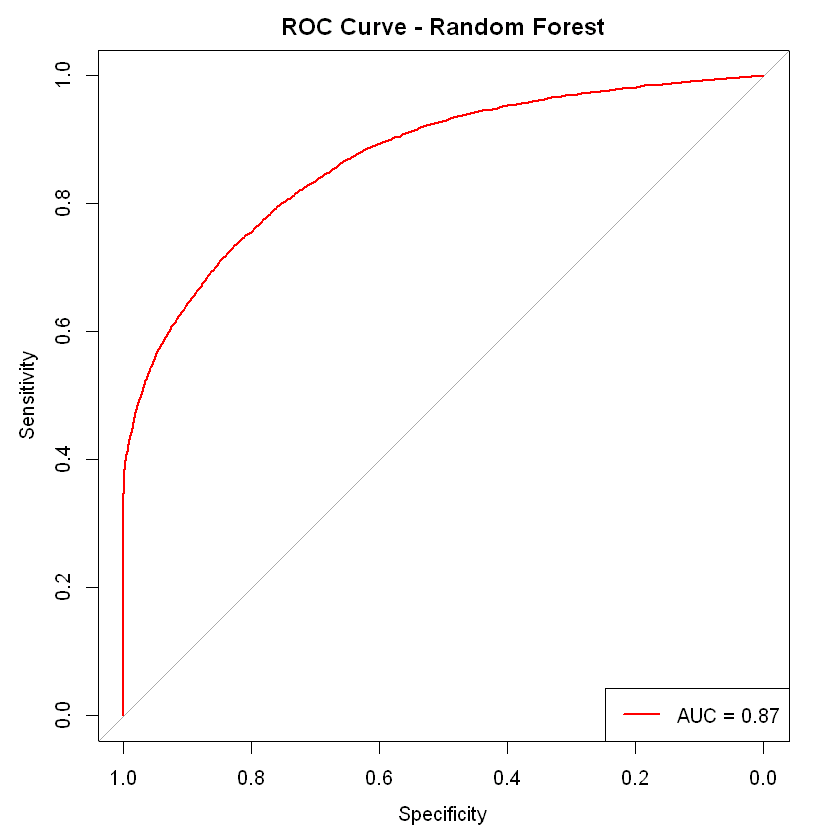

In [129]:

# Get predicted probabilities
rf_probabilities <- predict(rf_model, test_data, type = "prob")[,2]

# Compute ROC curve
rf_roc_curve <- roc(test_data$is_canceled, rf_probabilities)

# Plot ROC Curve
plot(rf_roc_curve, col = "red", main = "ROC Curve - Random Forest", lwd = 2)

# Compute AUC
rf_auc <- auc(rf_roc_curve)

# Add AUC to the plot
legend("bottomright", legend = paste("AUC =", round(rf_auc, 3)), col = "red", lwd = 2)




### ROC Curve for Random Forest Model

The **ROC Curve (Receiver Operating Characteristic)** visualises the trade-off between the model's sensitivity (true positive rate) and specificity (false positive rate) at various thresholds.

#### Key Observations:
- The curve rises sharply, indicating that the model performs well in distinguishing between cancellations and non-cancellations.
- **AUC (Area Under the Curve)**: **0.87**
  - An AUC value of 0.87 suggests strong discriminatory power, where the model effectively differentiates between the two classes (cancellations and non-cancellations).

#### Insights:
- The high AUC reflects the Random Forest model's ability to predict cancellations with a good balance of sensitivity and specificity.
- This supports the model's robustness for cancellation prediction in hotel bookings.


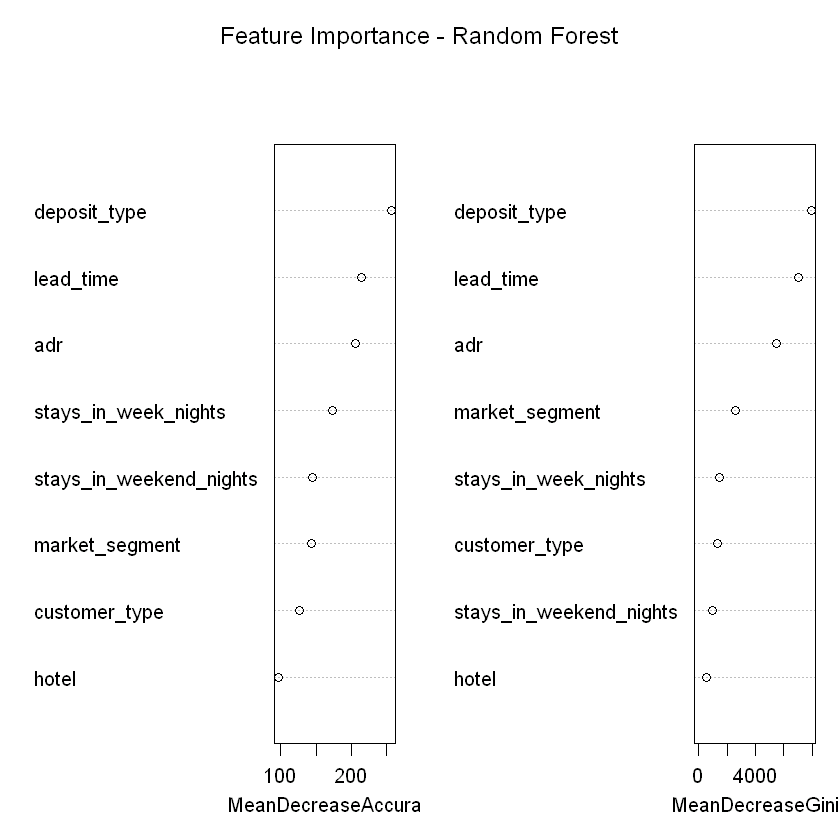

In [135]:
# Plot feature importance
varImpPlot(rf_model, main = "Feature Importance - Random Forest")

# Extract numerical importance values
feature_importance <- as.data.frame(importance(rf_model))
feature_importance$Feature <- rownames(feature_importance)

# Print top features
#feature_importance <- feature_importance[order(-feature_importance$MeanDecreaseGini), ]
#print(feature_importance)


### Feature Importance - Random Forest Model

The **Feature Importance Plot** shows which variables are most important for making accurate predictions in the Random Forest model. It uses two key measures:

1. **Mean Decrease Accuracy**: This shows how much the model's accuracy drops if a variable is removed. Higher values mean the variable is very important.
2. **Mean Decrease Gini**: This measures how much a variable helps reduce "disorder" (or impurity) in the data when the decision tree splits. Lower impurity means better separation of classes.

#### Key Findings:
- **Most Important Variables**:
  - **Deposit Type**: The strongest predictor of cancellations, showing that the type of deposit is crucial in determining whether a booking gets cancelled.
  - **Lead Time**: Highly influential, with longer lead times being associated with more cancellations.
  - **ADR (Average Daily Rate)**: Reflects how pricing impacts cancellations.
- Other significant variables:
  - **Stays in Week Nights** and **Stays in Weekend Nights**: Capture patterns in the length of stay.
  - **Market Segment**: Highlights how customer groups relate to cancellations.

#### Insights:
- The deposit type and lead time are the most critical factors influencing cancellations. This suggests that financial and booking behaviour play a major role.
- Hotels can focus on these key variables to develop strategies for reducing cancellations, such as offering flexible deposit options or targeting specific customer segments.


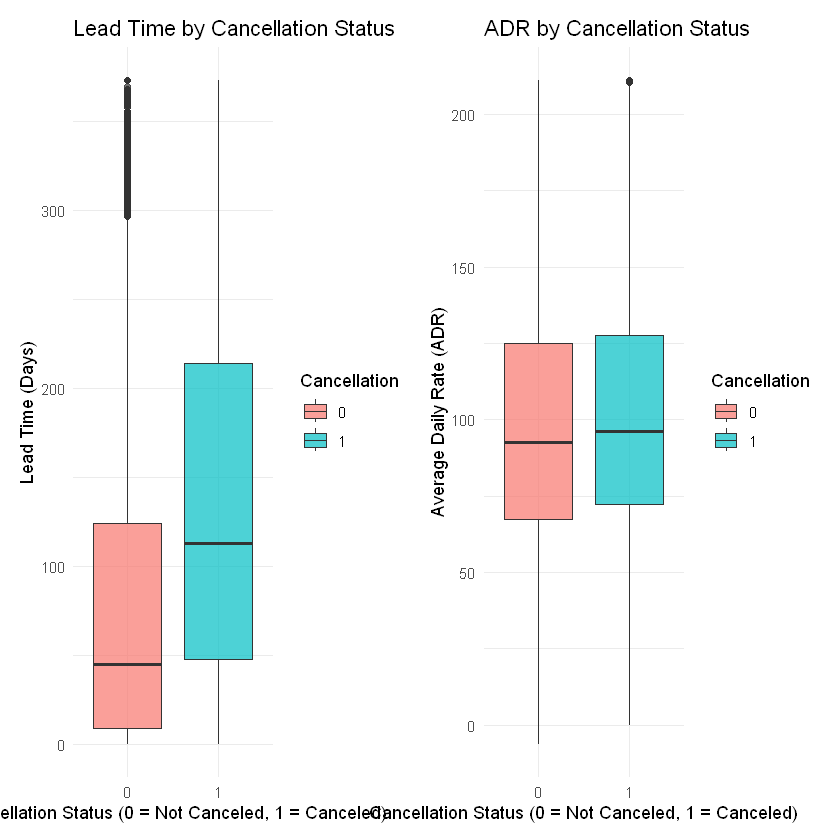

In [137]:
# Boxplot for Lead Time by Cancellation Status
boxplot_lead_time <- ggplot(hotel_data, aes(x = factor(is_canceled), y = lead_time, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Lead Time by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Lead Time (Days)",
    fill = "Cancellation"
  ) +
  theme_minimal()

# Boxplot for ADR by Cancellation Status
boxplot_adr <- ggplot(hotel_data, aes(x = factor(is_canceled), y = adr, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "ADR by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Average Daily Rate (ADR)",
    fill = "Cancellation"
  ) +
  theme_minimal()

# Combine the two plots side by side
boxplot_lead_time + boxplot_adr


### Boxplots of Key Features by Cancellation Status

The boxplots below examine the relationship between two critical features and cancellation status:

1. **Lead Time by Cancellation Status**:
   - Bookings that were cancelled tend to have significantly higher lead times compared to those that were not cancelled.
   - This indicates that bookings made far in advance are more likely to be cancelled, highlighting lead time as a crucial predictor of cancellations.

2. **Average Daily Rate (ADR) by Cancellation Status**:
   - The ADR distribution shows a slight difference between cancelled and non-cancelled bookings.
   - Cancelled bookings generally exhibit a marginally higher ADR, suggesting that price sensitivity might influence cancellation behaviour.

#### Insights:
- **Lead Time** is a strong differentiator between cancelled and non-cancelled bookings, making it an essential factor for predictive modelling.
- ADR provides additional insights into the economic aspects of cancellations, albeit with a less pronounced difference.


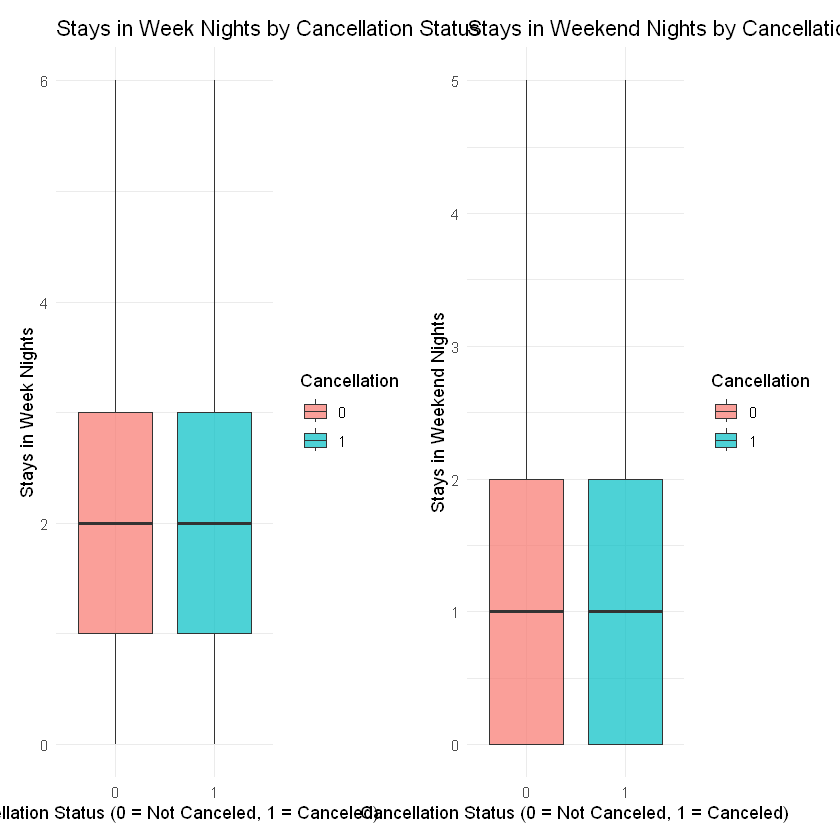

In [127]:
# Boxplot for Stays in Week Nights by Cancellation Status
boxplot_week_nights <- ggplot(hotel_data, aes(x = factor(is_canceled), y = stays_in_week_nights, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Stays in Week Nights by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Stays in Week Nights",
    fill = "Cancellation"
  ) +
  theme_minimal()

# Boxplot for Stays in Weekend Nights by Cancellation Status
boxplot_weekend_nights <- ggplot(hotel_data, aes(x = factor(is_canceled), y = stays_in_weekend_nights, fill = factor(is_canceled))) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Stays in Weekend Nights by Cancellation Status",
    x = "Cancellation Status (0 = Not Canceled, 1 = Canceled)",
    y = "Stays in Weekend Nights",
    fill = "Cancellation"
  ) +
  theme_minimal()

# Combine the two plots side by side
boxplot_week_nights + boxplot_weekend_nights


### Stays in Week Nights and Weekend Nights by Cancellation Status

The boxplots above compare the number of **Stays in Week Nights** and **Stays in Weekend Nights** between bookings that were cancelled (`1`) and those that were not (`0`).

#### Observations:
- For both **Stays in Week Nights** and **Stays in Weekend Nights**, there is no significant difference in the median values between cancelled and non-cancelled bookings.
- However, the distributions indicate that non-cancelled bookings may slightly favour shorter stays, while cancelled bookings include a slightly broader range of stay lengths.
- The variability in stay durations appears similar for both week and weekend stays, suggesting that length of stay alone may not be a strong predictor of cancellations.

#### Insights:
These findings highlight that while length of stay contributes some information, it is not a definitive factor in determining cancellation likelihood. Hotels may need to look at other factors, such as booking behaviour or customer segments, to better understand cancellation trends.


# **Business Insights & Conclusion**

Based on our analysis, hotels can take the following actionable steps:

- **Reduce long lead-time cancellations**: Offer discounts for early bookings that are non-refundable to encourage commitment.
- **Encourage deposits**: Customers who pay upfront are more likely to follow through with their bookings, reducing cancellations.
- **Adjust pricing strategies**: Tailor pricing for different market segments to minimise high-risk cancellations.
- **Monitor online travel agency bookings**: These bookings tend to have a higher cancellation rate and may require additional policies or incentives.


### Summary

This analysis explored factors influencing booking cancellations and assessed the predictive accuracy of machine learning models. Through data visualisation, statistical summaries, and model evaluation, several key findings were identified.

#### Key Influencing Factors:
1. **Lead Time**: Longer lead times significantly increase the likelihood of cancellations, suggesting customers booking far in advance are more prone to changing plans.
2. **Deposit Type**: Non-refundable deposits strongly reduce cancellations, highlighting their effectiveness in securing bookings.
3. **Market Segment**: Online bookings and groups are more likely to cancel, reflecting distinct customer behaviours in these segments.
4. **Economic Factors (ADR)**: Higher average daily rates (ADR) are associated with increased cancellations, potentially due to price sensitivity.

#### Predictive Modelling:
- Two models were developed to predict booking cancellations: **Logistic Regression** and **Random Forest**.
- The **Random Forest model** achieved higher predictive accuracy (80.5%) compared to Logistic Regression (75.5%), with an AUC of 0.87, indicating a strong ability to distinguish between cancelled and non-cancelled bookings.
- Feature importance analysis revealed that **deposit type**, **lead time**, and **ADR** are the most critical predictors of cancellations.

#### Conclusion:
The analysis highlights that financial conditions (e.g., deposit type) and booking behaviours (e.g., lead time and market segment) are key factors driving cancellations. The Random Forest model demonstrated robust performance, providing an effective tool for predicting cancellations and enabling hotels to take proactive measures to reduce them. Insights from this study can help hotels optimise booking policies, improve revenue management, and enhance customer satisfaction.
